# 3. Analysis
## 3.3. Q3. Frequency of catchy slogans

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%run "0.1. Intro_Visualization style.ipynb"

In [3]:
%run "3.0. Analysis_Functions.ipynb"

## Data loading

In [4]:
# Path to tokenized data
file = 'data/df_tokenized.csv'

In [5]:
df_tokenized = pd.read_csv(file)
df_tokenized.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
# Prepare columns with dates
df_tokenized['dat'] = pd.to_datetime(df_tokenized['dat'])
df_tokenized['datetime'] = pd.to_datetime(df_tokenized['date'])
df_tokenized['year_month'] = pd.to_datetime(df_tokenized['year_month'].astype(str), 
                                            format='%Y-%m')

In [7]:
# Make all columns lower case
for col in ['tags_top', 'title', 'body', 'tags_bottom', 'body_token_final', 'title_token_final']:
    df_tokenized[col] = df_tokenized[col].str.lower()

In [8]:
df_tokenized['video_duration_min'] = df_tokenized['video_duration_seconds'] / 60

In [9]:
df_tokenized.head(3)

,id_in_source_file,date,tags_top,title,url,body,tags_bottom,video_duration_seconds,file_key,datetime,dat,year,year_month,hour,weekday,whole newscast,body_token_final,title_token_final,video_duration_min
0,15,2023-01-27 21:45:00,общество,выпуск программы «время» в 21:00 от 27.01.2023,https://www.1tv.ru/news/2023-01-27/446104-vypu...,смотрите в этом выпуске: 79 лет назад была пол...,общество,2422.0,0-15,2023-01-27 21:45:00,2023-01-27,2023,2023-01-01,21,4,True,"['смотреть', 'выпуск', '79', 'год', 'полностью...","['выпуск', 'программа', 'время', '21:00', '27....",40.366667
1,16,2023-01-27 21:35:00,культура,в москве проходит церемония вручения премии «з...,https://www.1tv.ru/news/2023-01-27/446121-v_mo...,событие в мире отечественного кино. в москве в...,"культура,кино,марина зудина,екатерина климова,...",290.0,0-15,2023-01-27 21:35:00,2023-01-27,2023,2023-01-01,21,4,False,"['событие', 'мир', 'отечественный', 'кино', 'м...","['москва', 'проходить', 'церемония', 'вручение...",4.833333
2,20,2023-01-27 21:34:00,спорт,в туле появился новый футбольный манеж,https://www.1tv.ru/news/2023-01-27/446120-v_tu...,футбольный манеж в туле — искусственный газон ...,"спорт,регионы,футбол,алексей дюмин,тульская об...",48.0,0-15,2023-01-27 21:34:00,2023-01-27,2023,2023-01-01,21,4,False,"['футбольный', 'манеж', 'тула', 'искусственный...","['тула', 'появиться', 'новый', 'футбольный', '...",0.800000


## Estimating the duration of news stories featuring catchy slogans

In [10]:
# List of catchy slogans for analysis
slogans = [
    ['коллективный запад', 'коллективном западе', 'коллективному западу', 'коллективного запада'],
    ['своих не бросаем'],
    ['мы вместе', 'мывместе'],
    ['все для победы', 'всё для победы'],
    ['традиционные ценности', 'традиционных ценностях', 'традиционным ценностям', 'традиционных ценностей'],
    ['грязная бомба', 'грязную бомбу', 'грязной бомбы', 'грязной бомбе']
]

In [11]:
def slogans_duration(df, slogans):
    """
    Calculates the duration of news featuring slogans
    Args:
    df - dataframe
    slogans - list of lists
    
    Returns:
    df_duration - dataframe with total daily duration
                  of news containing slogans
    """
    
    # Filter newscasts, so we don't double duration of news releases
    df = df[df['whole newscast']==False].copy()
    
    # Analysis for the first slogan
    slogan = slogans[0]
    # Mark news stories containing slogans
    token_dict = {'body': slogan,
                  'title': slogan}
    slogan_df = find_tokens(df, token_dict)
    # Calculate duration of news
    slogan_df['video_duration_slogan'] = slogan_df['video_duration_min'] * slogan_df['contain_token'] 
    duration_df = slogan_df.groupby('year_month')[['video_duration_slogan']].sum()
    duration_df.rename(columns={'video_duration_slogan': 'slogan0'}, inplace=True)
    duration_df['EMA_slogan0'] = duration_df['slogan0'].ewm(alpha=0.3).mean()
    
    # Analysis for the rest of slogans
    indx=1
    for slogan in slogans[1:]:
        
        # Mark news stories containing slogans
        # 1 - contains; 0 - doesn't contain
        token_dict = {'body': slogan,
                      'title': slogan}
        
        slogan_df = find_tokens(df, token_dict)
        
        # Calculate duration of news
        slogan_df['video_duration_slogan'] = slogan_df['video_duration_min'] * slogan_df['contain_token'] 
        duration_df['slogan'+str(indx)] = slogan_df.groupby('year_month')[['video_duration_slogan']].sum()
        duration_df['EMA_slogan'+str(indx)] = duration_df['slogan'+str(indx)].ewm(alpha=0.3).mean()
        indx += 1
    
    return duration_df       

In [12]:
slogan_duration_df = slogans_duration(df_tokenized, slogans)
slogan_duration_df['year'] = slogan_duration_df.index.year 

## Visualization

In [13]:
# Get year >=2013 for pictures
slogan_duration_df = slogan_duration_df[slogan_duration_df['year']>=2013]

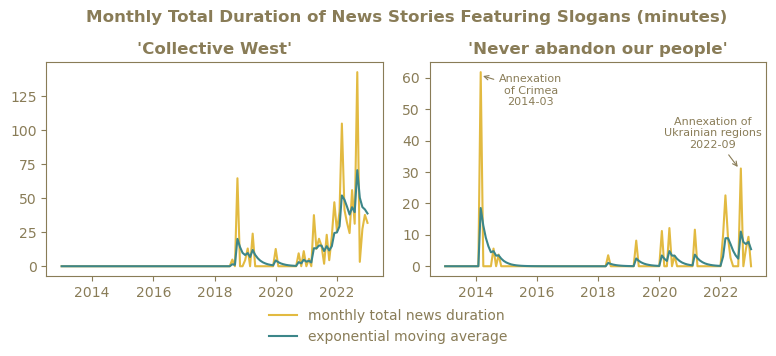

In [14]:
# Create plots
fig, ax = plt.subplots(1, 2, figsize=(9,3.5))

ax[0].plot(slogan_duration_df.index, 
           slogan_duration_df['slogan0'], 
           color=color_2,
           label='monthly total news duration')
ax[0].plot(slogan_duration_df.index, 
           slogan_duration_df['EMA_slogan0'], 
           color=color_1,
           label='exponential moving average')

ax[1].plot(slogan_duration_df.index, 
           slogan_duration_df['slogan1'], 
           color=color_2,
           label='monthly total news duration')
ax[1].plot(slogan_duration_df.index, 
           slogan_duration_df['EMA_slogan1'], 
           color=color_1,
           label='exponential moving average')
# Annotation
ax[1].annotate('Annexation\nof Crimea\n2014-03', 
             xy=(0.15, 0.94), xycoords='axes fraction', 
             xytext=(0.3, 0.8), textcoords='axes fraction',
             fontsize=8, color=color_txt_labels, horizontalalignment='center',
             arrowprops=dict(arrowstyle='->, head_width=0.2', 
                             color=color_txt_labels, linewidth=0.8))

ax[1].annotate('Annexation of\nUkrainian regions\n2022-09', 
             xy=(0.92, 0.5), xycoords='axes fraction', 
             xytext=(0.84, 0.6), textcoords='axes fraction',
             fontsize=8, color=color_txt_labels, horizontalalignment='center',
             arrowprops=dict(arrowstyle='->, head_width=0.2', 
                             color=color_txt_labels, linewidth=0.8))

ax[0].title.set_text("'Collective West'")
ax[1].title.set_text("'Never abandon our people'")

# Add more space between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.22,
                    right=0.9,
                    top=0.83,
                    wspace=0.14)

# Add a legend
lines_labels = ax[0].get_legend_handles_labels()
lines = lines_labels[0]
labels = lines_labels[1]
plt.figlegend(lines, labels, loc = 'lower center', frameon=False)



plt.suptitle('Monthly Total Duration of News Stories Featuring Slogans (minutes)',
             size=12, weight='bold');
